# Complete Mathematical Theory of Polynomial Regression – From Foundations to Advanced Diagnosis & Extensions

----
<div align="center"><h2>📘 Polynomial Regression — Theory · Diagnosis · Practice</h2></div>

> This notebook is designed as: graduate-level lecture notes, exam-ready revision, and a professional reference for interviews.

## Learning Objectives & Why Polynomial Regression Matters

**Learning objectives**
- Build intuition for when linear models fail and polynomial models help.
- Derive polynomial regression as linear regression in transformed feature space.
- Understand numerical issues (Vandermonde ill-conditioning) and how to fix them.
- Master regularization, model selection, alternative bases (Chebyshev, Legendre), splines, and diagnostics.

**Why it matters**
- Real-world relationships are often nonlinear but approximately polynomial locally.
- Polynomial regression provides a simple, interpretable, and analyzable nonlinear model.
- Serves as foundation to splines, GAMs, kernels, and nonparametric regression.

# Section 1: Motivation – Why Linear Isn’t Enough

### Real-world examples where relationships are nonlinear
- Physics: projectile motion (quadratic).  
- Biology: dose-response curves (nonlinear).  
- Economics: diminishing returns.  

### Limitations of simple linear regression
- Linear model cannot capture curvature; residuals show systematic patterns; poor predictive performance when relationship is nonlinear.

# Section 2: Mathematical Formulation

Start from simple linear model:
$$
y = \beta_0 + \beta_1 x + \varepsilon,
$$
Polynomial regression of degree $k$:
$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots + \beta_k x^k + \varepsilon.
$$
Define feature transform (monomials):
$$
\Phi(x) = [1, x, x^2, \dots, x^k]^T.
$$
Then polynomial regression is linear regression in the transformed space: $$y \approx \Phi(x)^T \beta$$.

# Section 3: Matrix Form & Closed-Form Solution

Given data $(x^{(i)}, y^{(i)})_{i=1}^n$, build Vandermonde design matrix $X$ with rows $\Phi(x^{(i)})^T$:
$$
X = \begin{bmatrix}
1 & x^{(1)} & (x^{(1)})^2 & \dots & (x^{(1)})^k \\
1 & x^{(2)} & (x^{(2)})^2 & \dots & (x^{(2)})^k \\
\vdots & \vdots & \vdots & & \vdots \\
1 & x^{(n)} & (x^{(n)})^2 & \dots & (x^{(n)})^k 
\end{bmatrix}.
$$
Normal equations (OLS):
$$
\hat{\beta} = (X^T X)^{-1} X^T y.
$$
### Numerical instability & ill-conditioning
- Vandermonde matrices become extremely ill-conditioned as degree $k$ increases.
- Small floating errors get amplified; solving normal equations directly is numerically unstable.

We will **visualize condition number** and discuss remedies (orthogonal polynomials, scaling, regularization).

In [1]:
# Cell: imports and global settings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import cond
sns.set_theme(style='whitegrid')
np.random.seed(0)


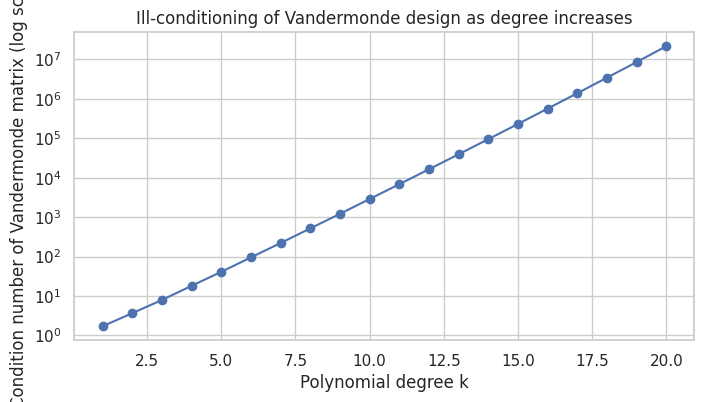

In [2]:
# Cell: Vandermonde condition number visualization
xs = np.linspace(-1, 1, 50)
degrees = list(range(1, 21))
conds = []
for k in degrees:
    V = np.vander(xs, N=k+1, increasing=True)
    conds.append(np.linalg.cond(V))

plt.figure(figsize=(8,4))
plt.semilogy(degrees, conds, marker='o')
plt.xlabel('Polynomial degree k')
plt.ylabel('Condition number of Vandermonde matrix (log scale)')
plt.title('Ill-conditioning of Vandermonde design as degree increases')
plt.show()


# Section 4: Overfitting & the Bias-Variance Trade-off

### Runge's phenomenon (classic example)
High-degree polynomial interpolation on evenly spaced points can oscillate wildly near edges — *Runge's phenomenon*.
We'll show training vs test error and visualize models for degrees 1..20.

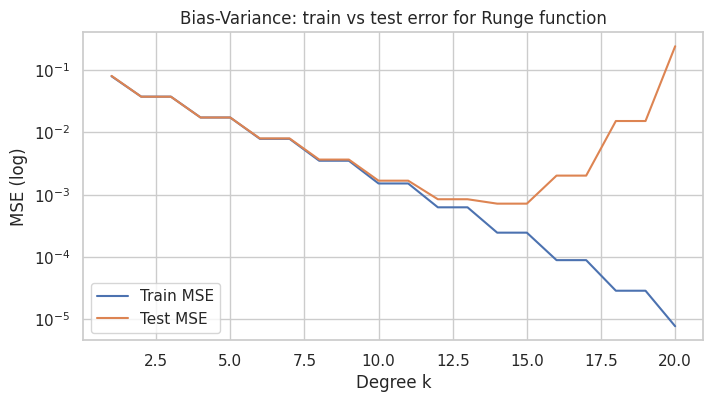

In [3]:
# Cell: Runge's function demo and train/test curves
def runge(x):
    return 1.0 / (1 + 25 * x**2)

n_train = 25
x_train = np.linspace(-1, 1, n_train)
y_train = runge(x_train)
x_test = np.linspace(-1, 1, 500)
y_test = runge(x_test)

from numpy.linalg import lstsq
train_errs = []
test_errs = []
models = {}
for k in range(1, 21):
    Vt = np.vander(x_train, N=k+1, increasing=True)
    coef, *_ = lstsq(Vt, y_train, rcond=None)
    models[k] = coef
    y_pred_train = Vt.dot(coef)
    train_errs.append(np.mean((y_train - y_pred_train)**2))
    Vy = np.vander(x_test, N=k+1, increasing=True)
    y_pred_test = Vy.dot(coef)
    test_errs.append(np.mean((y_test - y_pred_test)**2))

plt.figure(figsize=(8,4))
plt.plot(range(1,21), train_errs, label='Train MSE')
plt.plot(range(1,21), test_errs, label='Test MSE')
plt.yscale('log')
plt.xlabel('Degree k')
plt.ylabel('MSE (log)')
plt.title('Bias-Variance: train vs test error for Runge function')
plt.legend()
plt.show()


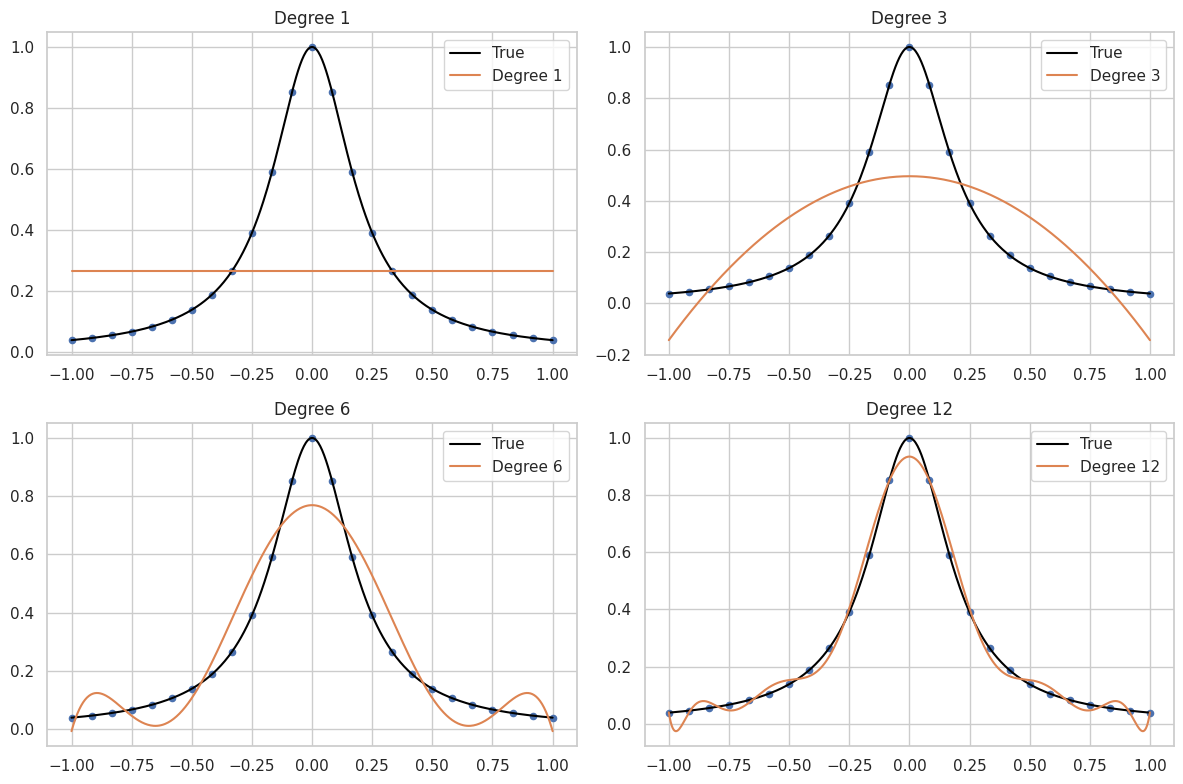

In [4]:
# Cell: visualize several fitted polynomials
plt.figure(figsize=(12,8))
ks = [1, 3, 6, 12]
for i, k in enumerate(ks, 1):
    coef = models[k]
    Vy = np.vander(x_test, N=k+1, increasing=True)
    y_pred = Vy.dot(coef)
    plt.subplot(2, 2, i)
    plt.plot(x_test, y_test, label='True', color='black')
    plt.plot(x_test, y_pred, label=f'Degree {k}', color='C1')
    plt.scatter(x_train, y_train, s=20)
    plt.title(f'Degree {k}')
    plt.legend()
plt.tight_layout()
plt.show()


# Section 5: Regularization for Polynomials

Ridge (L2), Lasso (L1), and Elastic Net penalize large coefficients and stabilize high-degree polynomials.
We show closed-form for Ridge and demonstration of coefficient shrinkage paths.

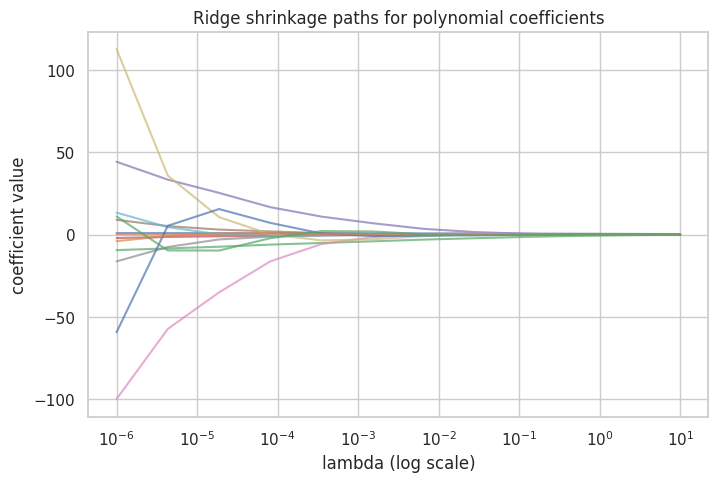

In [5]:
# Cell: Ridge closed-form for polynomial basis and coefficient path
from numpy.linalg import inv

def design_matrix(x, k):
    return np.vander(x, N=k+1, increasing=True)

x = np.linspace(-1, 1, 50)
y = runge(x) + 0.05*np.random.randn(len(x))
K = 12
V = design_matrix(x, K)
lambdas = np.logspace(-6, 1, 12)
coefs = []
for lam in lambdas:
    A = V.T.dot(V) + lam * np.eye(V.shape[1])
    b = V.T.dot(y)
    coef = np.linalg.solve(A, b)
    coefs.append(coef)
coefs = np.array(coefs)

plt.figure(figsize=(8,5))
for j in range(coefs.shape[1]):
    plt.semilogx(lambdas, coefs[:, j], label=f'coef {j}' if j<3 else None, alpha=0.7)
plt.xlabel('lambda (log scale)')
plt.ylabel('coefficient value')
plt.title('Ridge shrinkage paths for polynomial coefficients')
plt.show()


### Lasso and Elastic Net (sketch)
- Lasso requires iterative solvers (coordinate descent) and can set high-degree coefficients exactly to zero.  
- Elastic Net blends L1 and L2 to combine sparsity and grouped selection properties.

# Section 6: Model Selection & Cross-Validation

Selecting degree $k$ using validation and k-fold cross-validation. Information criteria: AIC, BIC, Mallow's Cp:

$$\mathrm{AIC} = 2p - 2\ell$$
$$\mathrm{BIC} = p\log n - 2\ell$$
For least squares with Gaussian errors, using residual sum of squares RSS and estimated variance, these reduce to formulas based on RSS.


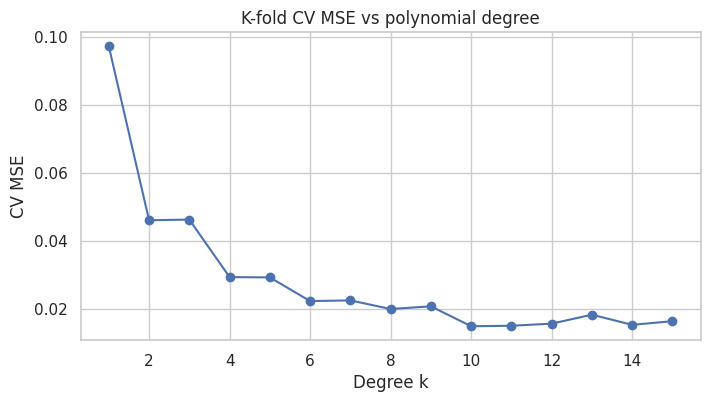

In [6]:
# Cell: k-fold CV to select degree (synthetic noisy function)
from sklearn.model_selection import KFold

def cv_mse_degree(x, y, max_k=15, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    mean_mse = []
    for k in range(1, max_k+1):
        mses = []
        for train_idx, val_idx in kf.split(x):
            V_train = np.vander(x[train_idx], N=k+1, increasing=True)
            beta, *_ = np.linalg.lstsq(V_train, y[train_idx], rcond=None)
            V_val = np.vander(x[val_idx], N=k+1, increasing=True)
            pred = V_val.dot(beta)
            mses.append(np.mean((pred - y[val_idx])**2))
        mean_mse.append(np.mean(mses))
    return mean_mse

x = np.linspace(-1,1,200)
y = runge(x) + 0.12*np.random.randn(len(x))
mean_mse = cv_mse_degree(x, y, max_k=15)
plt.figure(figsize=(8,4))
plt.plot(range(1,16), mean_mse, marker='o')
plt.xlabel('Degree k')
plt.ylabel('CV MSE')
plt.title('K-fold CV MSE vs polynomial degree')
plt.show()


# Section 7: Basis Functions Beyond Monomials

### Orthogonal polynomials (Legendre, Chebyshev)
- Orthogonal bases reduce numerical instability and collinearity.
- Chebyshev polynomials minimize maximum error on [-1,1].

### Splines, B-splines, Natural cubic splines
- Splines partition domain into pieces and fit low-degree polynomials with continuity constraints.
- Splines avoid global oscillation; better for high-degree flexible fits.

We demonstrate a simple spline vs polynomial fit.

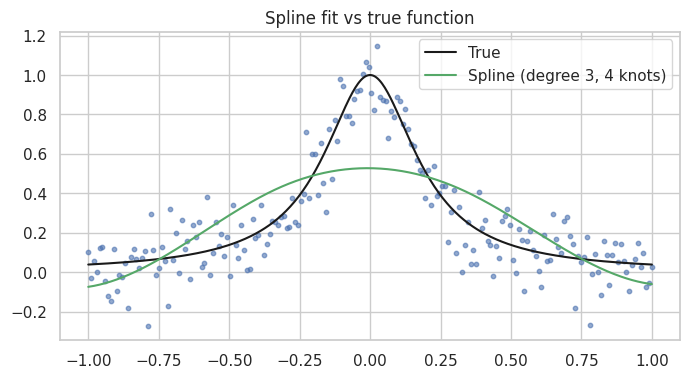

In [7]:
# Cell: Spline vs polynomial demonstration (using sklearn's spline transformer)
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

x = x.reshape(-1,1)
y = (1/(1+25*x.ravel()**2)) + 0.12*np.random.randn(len(x.ravel()))

poly_model = make_pipeline(SplineTransformer(degree=3, n_knots=4, knots='uniform', extrapolation='constant'), Ridge(alpha=1.0))
poly_model.fit(x, y)
xx = np.linspace(-1,1,400).reshape(-1,1)
yy_spline = poly_model.predict(xx)

plt.figure(figsize=(8,4))
plt.plot(xx, 1/(1+25*xx.ravel()**2), label='True', color='k')
plt.plot(xx, yy_spline, label='Spline (degree 3, 4 knots)', color='C2')
plt.scatter(x, y, s=10, alpha=0.6)
plt.legend()
plt.title('Spline fit vs true function')
plt.show()


# Section 8: Diagnostics Specific to Polynomial Regression

- Residuals vs fitted: look for structure; polynomial misspecification produces patterns.
- Partial residual plots reveal contribution of individual powers (careful interpretation due to collinearity).
- Leverage and influence: high-degree terms can create extreme leverage points.

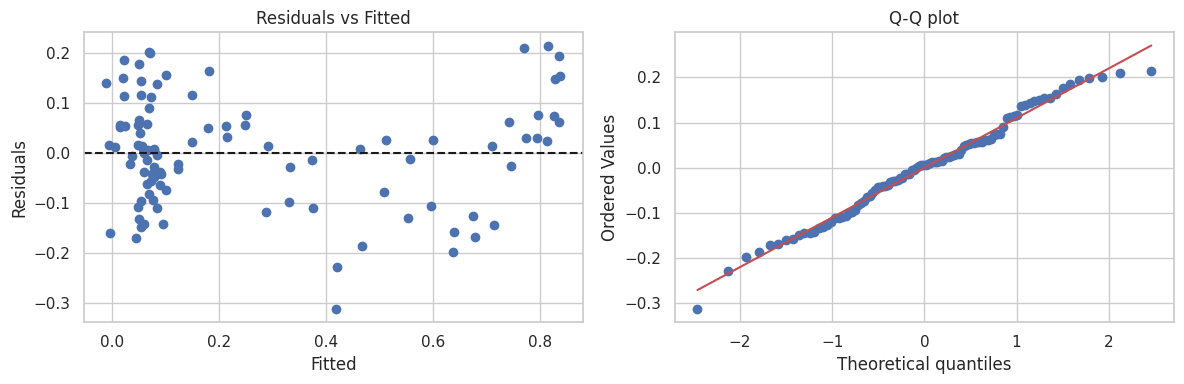

In [8]:
# Cell: Diagnostic plots for a fitted polynomial model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = np.linspace(-1,1,100).reshape(-1,1)
y = 1/(1+25*X.ravel()**2) + 0.08*np.random.randn(100)
poly = PolynomialFeatures(degree=8, include_bias=True)
V = poly.fit_transform(X)
lr = LinearRegression().fit(V, y)
y_pred = lr.predict(V)
residuals = y - y_pred

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(y_pred, residuals)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

plt.subplot(1,2,2)
import scipy.stats as stats
stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q plot')
plt.tight_layout()
plt.show()


# Section 9: Implementation from Scratch (NumPy only)

We provide: a PolynomialFeatureGenerator, OLS solver, Ridge closed-form, and a gradient-descent solver.

In [9]:
# Cell: From-scratch implementation
class PolyFeatureGenerator:
    def __init__(self, degree, include_bias=True):
        self.degree = degree
        self.include_bias = include_bias
    def transform(self, x):
        x = np.asarray(x).ravel()
        X = np.vander(x, N=self.degree+1, increasing=True)
        if not self.include_bias:
            return X[:,1:]
        return X

class PolyOLS:
    def __init__(self, degree):
        self.degree = degree
    def fit(self, x, y):
        pg = PolyFeatureGenerator(self.degree)
        X = pg.transform(x)
        self.coef_ = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
        return self
    def predict(self, x):
        pg = PolyFeatureGenerator(self.degree)
        X = pg.transform(x)
        return X.dot(self.coef_)

class PolyRidge(PolyOLS):
    def __init__(self, degree, alpha=1.0):
        super().__init__(degree)
        self.alpha = alpha
    def fit(self, x, y):
        pg = PolyFeatureGenerator(self.degree)
        X = pg.transform(x)
        n, p = X.shape
        A = X.T.dot(X) + self.alpha * n * np.eye(p)
        self.coef_ = np.linalg.solve(A, X.T.dot(y))
        return self

class PolyGD(PolyOLS):
    def __init__(self, degree, lr=1e-3, n_iter=5000):
        super().__init__(degree)
        self.lr = lr
        self.n_iter = n_iter
    def fit(self, x, y):
        pg = PolyFeatureGenerator(self.degree)
        X = pg.transform(x)
        n, p = X.shape
        w = np.zeros(p)
        for it in range(self.n_iter):
            grad = (-2/n) * X.T.dot(y - X.dot(w))
            w -= self.lr * grad
        self.coef_ = w
        return self


# Section 10: Professional scikit-learn Pipeline

Use `PolynomialFeatures`, `StandardScaler`, and regularized linear models. Avoid leakage by using `Pipeline` and cross-validation.

In [12]:
# Cell: sklearn pipeline example (synthetic)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

X = np.linspace(-1,1,300).reshape(-1,1)
y = 1/(1+25*X.ravel()**2) + 0.12*np.random.randn(X.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=np.logspace(-6,2,10)))
])

pipe.fit(X_train, y_train)

print('Selected degree (poly.degree):', pipe.named_steps['poly'].degree)

y_pred = pipe.predict(X_test)

print('Test MSE:', mean_squared_error(y_test, y_pred))
print('Test R2:', r2_score(y_test, y_pred))


Selected degree (poly.degree): 2
Test MSE: 0.05030821643072219
Test R2: 0.30771110235378984


# Section 11: Advanced Extensions

- **Multivariate polynomial regression**: include cross-terms and interactions. Beware combinatorial explosion (use degree truncation).
- **Interaction terms without full explosion**: use `PolynomialFeatures(degree=k, interaction_only=True)` or selective feature engineering.
- **Generalized Additive Models (GAMs)**: model as sum of smooth functions; splines and backfitting algorithm; more interpretable and scalable than full multivariate polynomials.

# Bonus: One-Page LaTeX Cheat Sheet

```
Model: y = \sum_{j=0}^k \beta_j x^j + \varepsilon
Design: X_{i,j} = (x^{(i)})^j
OLS: \hat{\beta} = (X^T X)^{-1} X^T y
Ridge: \hat{\beta}_\lambda = (X^T X + n\lambda I)^{-1} X^T y
CV: choose k minimizing CV MSE
Condition number: cond(V) grows rapidly with k for Vandermonde V
Splines: piecewise polynomials with continuity constraints; B-splines are stable basis
```


# Bonus: 10 Most Common Interview Questions & Model Answers

1. **When use polynomial regression?** When relationship is nonlinear but smooth and low-dimensional.
2. **Why Vandermonde is ill-conditioned?** Powers become huge/small and highly collinear; causes numerical instability.
3. **How to avoid overfitting?** Cross-validation, regularization, splines, or reduce degree.
4. **Ridge vs Lasso for polynomials?** Ridge shrinks coefficients; Lasso can zero high-degree terms.
5. **Why use orthogonal polynomials?** Numerical stability and uncorrelated basis functions.
6. **Explain Runge's phenomenon.** High-degree interpolation on equispaced points oscillates at boundaries.
7. **How choose knots for splines?** Use domain knowledge or quantiles; use CV.
8. **When use interaction_only?** When you want cross terms but not full polynomial expansion.
9. **How check polynomial degree adequacy?** Residual plots, CV, AIC/BIC.
10. **How to scale features?** Standardize inputs to reduce collinearity between powers and improve conditioning.


# References

- Hastie, Tibshirani, Friedman — *The Elements of Statistical Learning* (sections on basis expansions and splines).  
- James, Witten, Hastie, Tibshirani — *An Introduction to Statistical Learning* (polynomial regression & cross-validation).  
- Bishop — *Pattern Recognition and Machine Learning*.  
- Numerical Recipes — discussion on Vandermonde matrices and polynomial fitting.


----
### Notes and Warnings
- **Numerical stability**: avoid solving normal equations directly when Vandermonde is ill-conditioned; use orthogonal basis or regularization.  
- **Feature scaling**: center/scale inputs before creating powers to reduce dynamic range.  
- **Data leakage**: when using polynomial transforms, always fit scalers/transformers inside a Pipeline and apply transforms only on training folds during CV.